In [1]:
from time import time
import numpy as np
import keras.backend as K
from keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import numpy as np
from random import randint
import os
import matplotlib.pyplot as plt

import tensorflow_addons as tfa
import plotting_funcs as pf
import clustering_model as cm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.optimizers import Adam

In [2]:
X = np.load('../npy_files/features_All16.npy')
y = np.load('../npy_files/labels_All16.npy')
types = np.load('../npy_files/celltypes_All16.npy')
y_letter = np.array([well[:1] for well in y])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labs = le.fit_transform(y)
labs_by_letter = le.fit_transform(y_letter)
print(len(X),len(y))
X_train, y_train = X, labs
X_train.shape

29808 29808


(29808, 16, 5)

In [3]:
import preprocess_funcs as prep
X_train=prep.add_transformations(X_train)

In [26]:
X_train.shape

(29808, 16, 10)

In [27]:
# #cut area column
# x_cut = np.delete(X, 2, 2)
# X_train = x_cut.copy()
# X_train.shape

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_train.shape[1]

16

In [5]:
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape,LSTM,RepeatVector,Dense,TimeDistributed, \
Conv1D,LeakyReLU,MaxPool1D,Bidirectional,UpSampling2D,Input
from keras.models import Model,Sequential
def temporal_autoencoder(input_dim, timesteps, n_filters=50, kernel_size=10, strides=1, pool_size=10, n_units=[50, 1]):
    """
    Temporal Autoencoder (TAE) model with Convolutional and BiLSTM layers.

    # Arguments
        input_dim: input dimension
        timesteps: number of timesteps (can be None for variable length sequences)
        n_filters: number of filters in convolutional layer
        kernel_size: size of kernel in convolutional layer
        strides: strides in convolutional layer
        pool_size: pooling size in max pooling layer, must divide time series length
        n_units: numbers of units in the two BiLSTM layers

    # Return
        (ae_model, encoder_model, decoder_model): AE, encoder and decoder models
    """
    assert(timesteps % pool_size == 0)

    # Input
    x = Input(shape=(timesteps, input_dim), name='input_seq')

    # Encoder
    encoded = Conv1D(n_filters, kernel_size, strides=strides, padding='same', activation='linear')(x)
    #encoded = Conv1D(n_filters, kernel_size, strides=strides, padding='same', activation='linear',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    encoded = LeakyReLU()(encoded)
    encoded = MaxPool1D(pool_size)(encoded)
    encoded = Bidirectional(LSTM(n_units[0], return_sequences=True), merge_mode='sum')(encoded)
    encoded = LeakyReLU()(encoded)
    encoded = Bidirectional(LSTM(n_units[1], return_sequences=True), merge_mode='sum')(encoded)
    encoded = LeakyReLU(name='latent')(encoded)

    # Decoder
    decoded = Reshape((-1, 1, n_units[1]), name='reshape')(encoded)
    decoded = UpSampling2D((pool_size, 1), name='upsampling')(decoded)  #decoded = UpSampling1D(pool_size, name='upsampling')(decoded)
    decoded = Conv2DTranspose(input_dim, (kernel_size, 1), padding='same', name='conv2dtranspose')(decoded)
    output = Reshape((-1, input_dim), name='output_seq')(decoded)  #output = Conv1D(1, kernel_size, strides=strides, padding='same', activation='linear', name='output_seq')(decoded)

    # AE model
    autoencoder = Model(inputs=x, outputs=output, name='AE')

    # Encoder model
    encoder = Model(inputs=x, outputs=encoded, name='encoder')

    # Create input for decoder model
    encoded_input = Input(shape=(timesteps // pool_size, n_units[1]), name='decoder_input')

    # Internal layers in decoder
    decoded = autoencoder.get_layer('reshape')(encoded_input)
    decoded = autoencoder.get_layer('upsampling')(decoded)
    decoded = autoencoder.get_layer('conv2dtranspose')(decoded)
    decoder_output = autoencoder.get_layer('output_seq')(decoded)

    # Decoder model
    decoder = Model(inputs=encoded_input, outputs=decoder_output, name='decoder')

    return autoencoder, encoder, decoder

In [27]:
#model params
input_dim = X_train.shape[-1]
timesteps = X_train.shape[-2]
n_filters = 2000
kernel_size = 12
strides = 1
pool_size = 8
n_units = [100,6]

optimizer='adam'
#optimizer = Adam(lr=0.01)
loss = 'mse'
#loss = tf.keras.losses.Huber(delta=1.0, reduction="auto", name="huber_loss")
epochs=30
batch_size=256
save_dir='results/tmp'
verbose=1

In [28]:
autoencoder,encoder,decoder = temporal_autoencoder(input_dim,timesteps,n_filters,kernel_size,strides,pool_size,n_units)
autoencoder.compile(optimizer=optimizer, loss=loss)

In [29]:
autoencoder.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 16, 10)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 16, 2000)          242000    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 2000)          0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 2, 2000)          0         
 1D)                                                             
                                                                 
 bidirectional_8 (Bidirectio  (None, 2, 100)           1680800   
 nal)                                                            
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 2, 100)            0        

In [30]:
t0 = time()
autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=verbose)
print('Pretraining time: ', time() - t0)

Epoch 1/30
117/117 [==============================] - 26s 177ms/step - loss: 0.6901
Epoch 2/30
117/117 [==============================] - 20s 171ms/step - loss: 0.5835
Epoch 3/30
117/117 [==============================] - 20s 169ms/step - loss: 0.5601
Epoch 4/30
117/117 [==============================] - 20s 168ms/step - loss: 0.5470
Epoch 5/30
117/117 [==============================] - 19s 165ms/step - loss: 0.5382
Epoch 6/30
117/117 [==============================] - 19s 163ms/step - loss: 0.5313
Epoch 7/30
117/117 [==============================] - 20s 172ms/step - loss: 0.5260
Epoch 8/30
117/117 [==============================] - 21s 180ms/step - loss: 0.5233
Epoch 9/30
117/117 [==============================] - 21s 177ms/step - loss: 0.5204
Epoch 10/30
117/117 [==============================] - 20s 175ms/step - loss: 0.5197
Epoch 11/30
117/117 [==============================] - 21s 175ms/step - loss: 0.5183
Epoch 12/30
117/117 [==============================] - 19s 166ms/step - lo

(10, 16, 10)
1/1 [==============================] - 2s 2s/step


/Users/amosavni/university/DeepLearningWorkshop/deepcell_mod/DL-WORKSHOP/Clustering/plotting_funcs.py:85: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


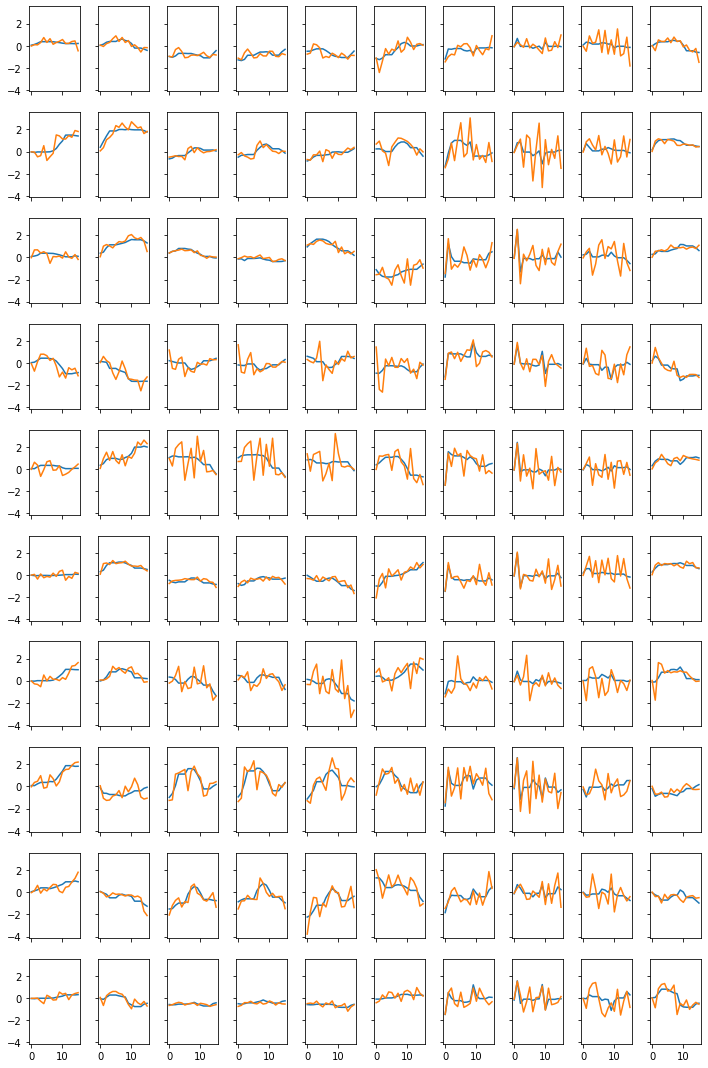

In [22]:
size = 10
rand_idx = np.random.choice(X_train.shape[0], size, replace=False)

orig_vec = X_train[rand_idx,:,:]
print(orig_vec.shape)

pred_vec = autoencoder.predict(orig_vec)

pf.plot_autoencoder_by_time(orig_vec,pred_vec)

/Users/amosavni/university/DeepLearningWorkshop/deepcell_mod/DL-WORKSHOP/Clustering/plotting_funcs.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


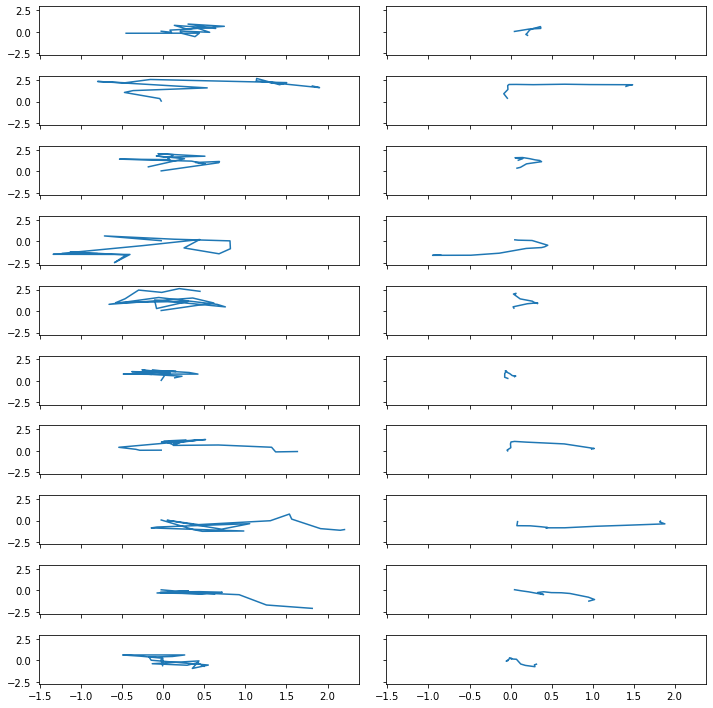

In [23]:
pf.plot_representatives([orig_vec,pred_vec])

In [16]:
import config
def plot_clustering(latent, clusters):

    clusters = clusters[:latent.shape[0]] # because of weird batch_size

    colors = [config.color_options[int(i)] for i in clusters]

    latent_pca = TruncatedSVD(n_components=2).fit_transform(latent)
    latent_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(latent)

    fig, axs = plt.subplots(2, figsize=(10,20),sharey=False,sharex=False)

    axs[0].scatter(latent_pca[:, 0], latent_pca[:, 1], c=colors, marker='*', linewidths=0)
    axs[0].set_title('PCA')

    axs[1].scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=colors, marker='*', linewidths=0)
    axs[1].set_title('tSNE')

    fig.show()

932/932 [==============================] - 18s 18ms/step


/var/folders/s6/khx_n6gj1fgfgkzsbv62f8sw0000gn/T/ipykernel_92489/3027661819.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


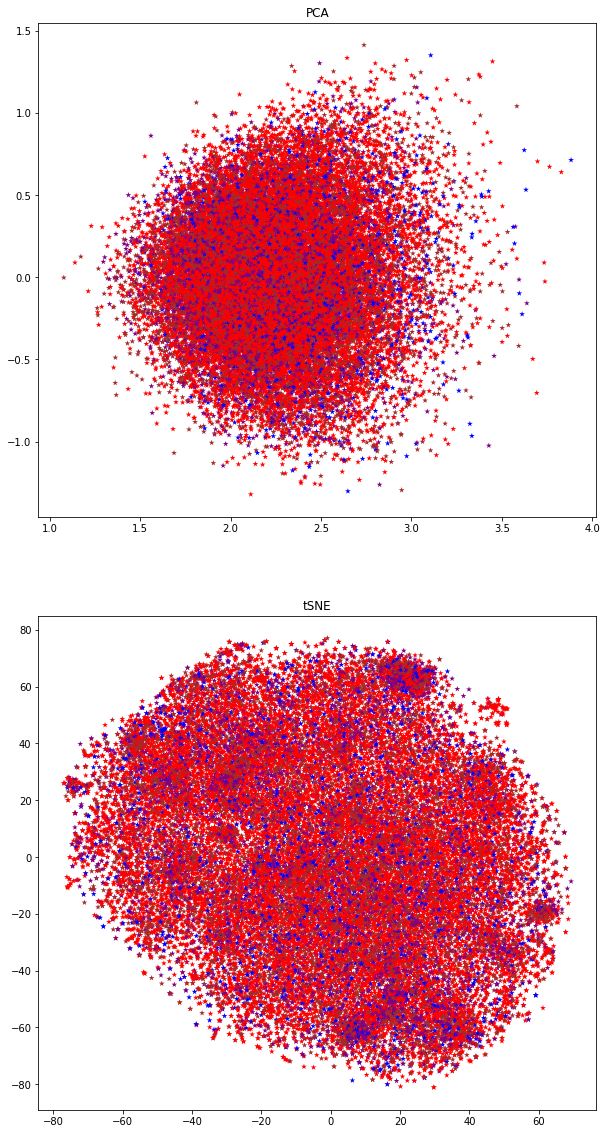

In [17]:
latent = encoder.predict(X_train)
latent = latent.reshape(latent.shape[0],latent.shape[1]*latent.shape[2])
labs_by_type = le.fit_transform(types)
plot_clustering(latent,labs_by_letter)

In [74]:
autoencoder,encoder,decoder = temporal_autoencoder(input_dim,timesteps,n_filters,kernel_size,strides,pool_size,n_units)
autoencoder.compile(optimizer=optimizer, loss=loss)

In [75]:
t0 = time()
autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=verbose)
print('Pretraining time: ', time() - t0)

Epoch 1/30
72/72 [==============================] - 15s 117ms/step - loss: 0.6081
Epoch 2/30
72/72 [==============================] - 9s 120ms/step - loss: 0.4434
Epoch 3/30
72/72 [==============================] - 8s 115ms/step - loss: 0.4037
Epoch 4/30
72/72 [==============================] - 8s 117ms/step - loss: 0.3826
Epoch 5/30
72/72 [==============================] - 9s 127ms/step - loss: 0.3669
Epoch 6/30
72/72 [==============================] - 9s 123ms/step - loss: 0.3561
Epoch 7/30
72/72 [==============================] - 9s 121ms/step - loss: 0.3512
Epoch 8/30
72/72 [==============================] - 9s 131ms/step - loss: 0.3542
Epoch 9/30
72/72 [==============================] - 9s 122ms/step - loss: 0.3449
Epoch 10/30
72/72 [==============================] - 9s 120ms/step - loss: 0.3398
Epoch 11/30
72/72 [==============================] - 8s 116ms/step - loss: 0.3385
Epoch 12/30
72/72 [==============================] - 9s 125ms/step - loss: 0.3369
Epoch 13/30
72/72 [=====

(10, 32, 5)
1/1 [==============================] - 2s 2s/step


/Users/amosavni/university/DeepLearningWorkshop/deepcell_mod/DL-WORKSHOP/Clustering/plotting_funcs.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


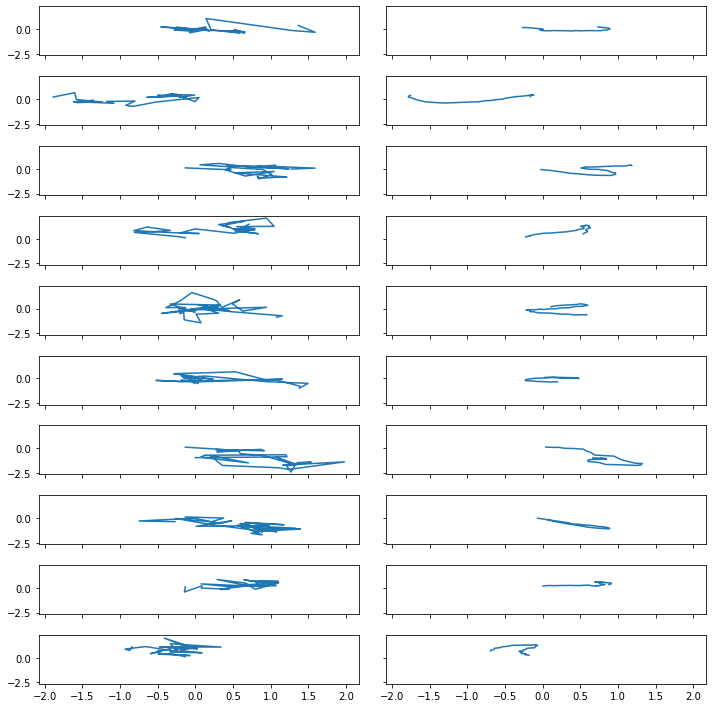

In [76]:
orig_vec = X_train[rand_idx,:,:]
print(orig_vec.shape)

pred_vec = autoencoder.predict(orig_vec)
pf.plot_representatives([orig_vec,pred_vec])

In [102]:
latent = encoder.predict(X_train)

144/144 [==============================] - 2s 12ms/step


In [106]:
latent = latent.reshape(latent.shape[0],latent.shape[1]*latent.shape[2])

In [107]:
labs_by_type = le.fit_transform(types)

/var/folders/s6/khx_n6gj1fgfgkzsbv62f8sw0000gn/T/ipykernel_69650/3027661819.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


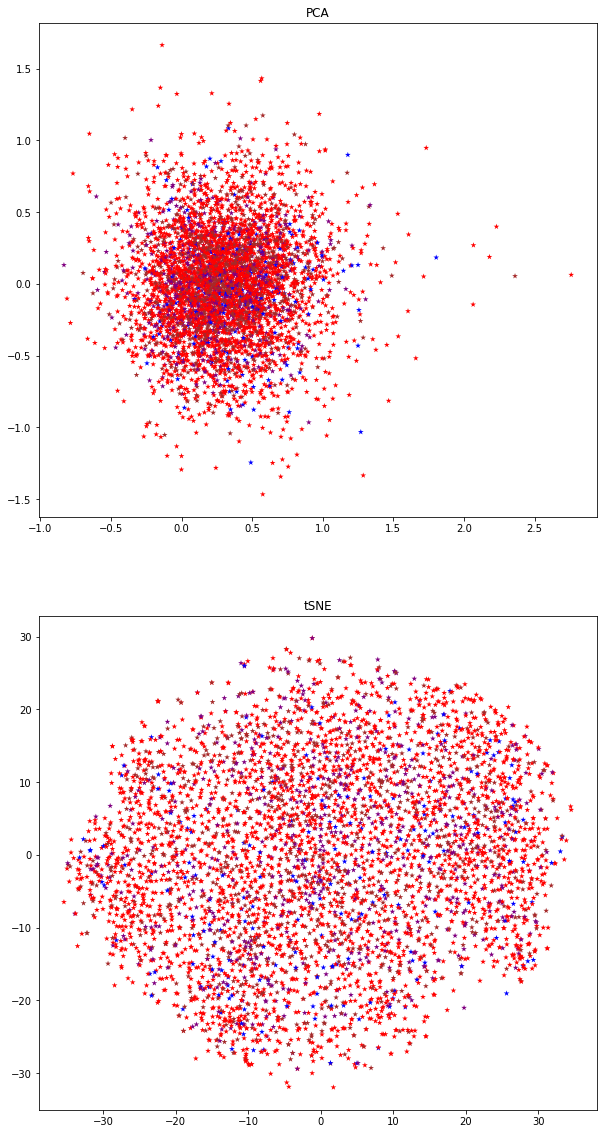

In [114]:
plot_clustering(latent,labs_by_letter)